In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw------- 1 root root 70 May 10 13:45 /root/.kaggle/kaggle.json


In [2]:

!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0


In [3]:
!unzip breast-ultrasound-images-dataset.zip -d breast_ultrasound_data

Archive:  breast-ultrasound-images-dataset.zip
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: breast_ultrasound_data/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: b

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from PIL import Image
from collections import Counter
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [5]:
masks = glob.glob("/content/breast_ultrasound_data/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

series = list(zip(images, masks, labels))

In [6]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])

    f, axarr = plt.subplots(1, 3, figsize=(5, 5))

    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel(image_mask[2], fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

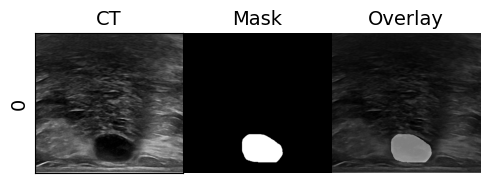

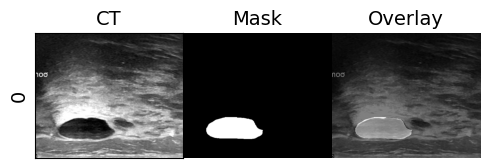

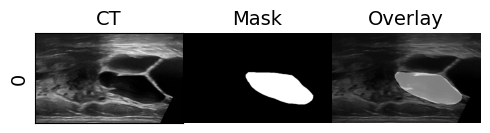

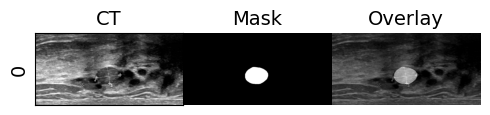

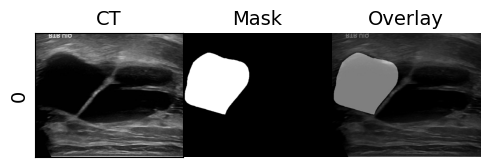

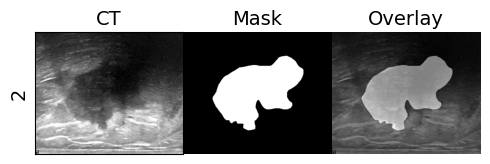

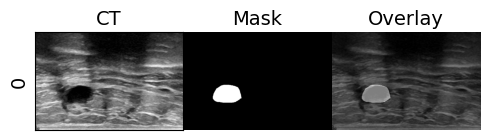

In [7]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [8]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [9]:
dataset = dataset[['image_path', 'labels']]

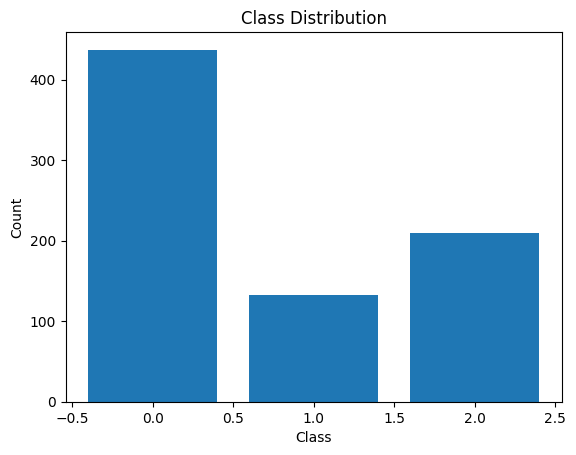

In [10]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [11]:
dataset

,image_path,labels
0,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
1,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
2,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
3,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
4,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
...,...,...
775,/content/breast_ultrasound_data/Dataset_BUSI_w...,0
776,/content/breast_ultrasound_data/Dataset_BUSI_w...,0
777,/content/breast_ultrasound_data/Dataset_BUSI_w...,0
778,/content/breast_ultrasound_data/Dataset_BUSI_w...,0


In [12]:

aug_path = '/kaggle/working/augmented_images/'
image_paths = dataset['image_path'].values
labels = dataset['labels'].values

if not os.path.exists(aug_path):
    os.makedirs(aug_path)


label_counts = Counter(labels)


target_count = max(label_counts.values())

combined_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

In [13]:
label_counts[0] - label_counts[1]

304

In [14]:
for i in [1, 2]:
    num_augmentations = label_counts[0] - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    for j in range(num_augmentations):
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        rotated_image = combined_transform(image.copy())

        rotated_image_np = np.array(rotated_image)
        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, rotated_image_np)

In [15]:
images = glob.glob("/kaggle/working/augmented_images/*.png")
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

new_series = list(zip(images, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [16]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [17]:
concatenated_df

,image_path,labels
0,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
1,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
2,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
3,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
4,/content/breast_ultrasound_data/Dataset_BUSI_w...,1
...,...,...
1035,/kaggle/working/augmented_images/malignant (47...,2
1036,/kaggle/working/augmented_images/malignant (55...,2
1037,/kaggle/working/augmented_images/malignant (17...,2
1038,/kaggle/working/augmented_images/normal (73).png,1


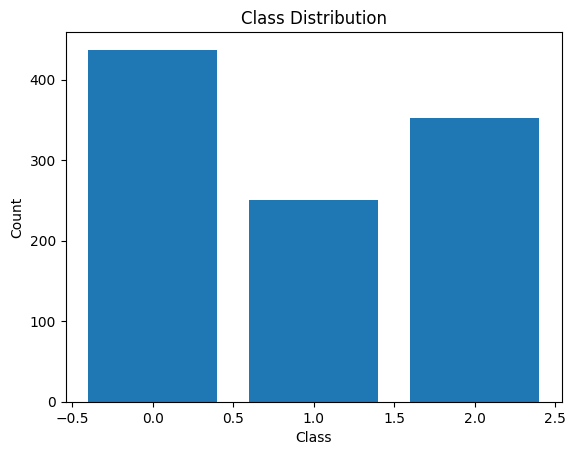

In [18]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [19]:
train, test= train_test_split(concatenated_df, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)

In [20]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)

        return image, label

In [21]:
image_size = 256

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)


batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for batch in train_dataloader:

    inputs, targets = batch

    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / len(val_loader.dataset)
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics

In [25]:
from torchvision import models

model_effnet = models.efficientnet_b7(pretrained=True)

model_mobilenet = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 178MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 197MB/s]


In [26]:
import torch
import torch.nn as nn
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_effnet = models.efficientnet_b0(pretrained=True)
model_effnet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1280, 2024),
    nn.ReLU(inplace=True),
    nn.Linear(2024, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 3)
)

model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 3)

models_dict = {
    model_effnet: 'EfficientNet',
    model_mobilenet: 'MobileNet'
}


for model, name in models_dict.items():
    for param in model.parameters():
        if param.requires_grad:
            break
    else:
        for param in model.parameters():
            param.requires_grad = False

    model.to(device)
    print(f'The model {name} is ready!')
print('-'*35)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


The model EfficientNet is ready!
The model MobileNet is ready!
-----------------------------------


In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 4))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0


        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train


        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val


        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['val_accuracy'].append(val_accuracy)


        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


    plot_metrics(metrics)



Training and Evaluating for EfficientNet!
-----------------------------------
Epoch 1/10 => Train Loss: 0.9407, Train Accuracy: 0.5330 | Val Loss: 1.0280, Val Accuracy: 0.4295
Epoch 2/10 => Train Loss: 0.4772, Train Accuracy: 0.8324 | Val Loss: 0.3687, Val Accuracy: 0.8654
Epoch 3/10 => Train Loss: 0.2607, Train Accuracy: 0.9080 | Val Loss: 0.2920, Val Accuracy: 0.8910
Epoch 4/10 => Train Loss: 0.2077, Train Accuracy: 0.9245 | Val Loss: 0.3296, Val Accuracy: 0.8718
Epoch 5/10 => Train Loss: 0.0741, Train Accuracy: 0.9766 | Val Loss: 0.4103, Val Accuracy: 0.8846
Epoch 6/10 => Train Loss: 0.0699, Train Accuracy: 0.9794 | Val Loss: 0.3912, Val Accuracy: 0.8910
Epoch 7/10 => Train Loss: 0.1023, Train Accuracy: 0.9684 | Val Loss: 0.4859, Val Accuracy: 0.8846
Epoch 8/10 => Train Loss: 0.1186, Train Accuracy: 0.9615 | Val Loss: 0.3937, Val Accuracy: 0.9231
Epoch 9/10 => Train Loss: 0.0630, Train Accuracy: 0.9808 | Val Loss: 0.4099, Val Accuracy: 0.9103
Epoch 10/10 => Train Loss: 0.0404, Train

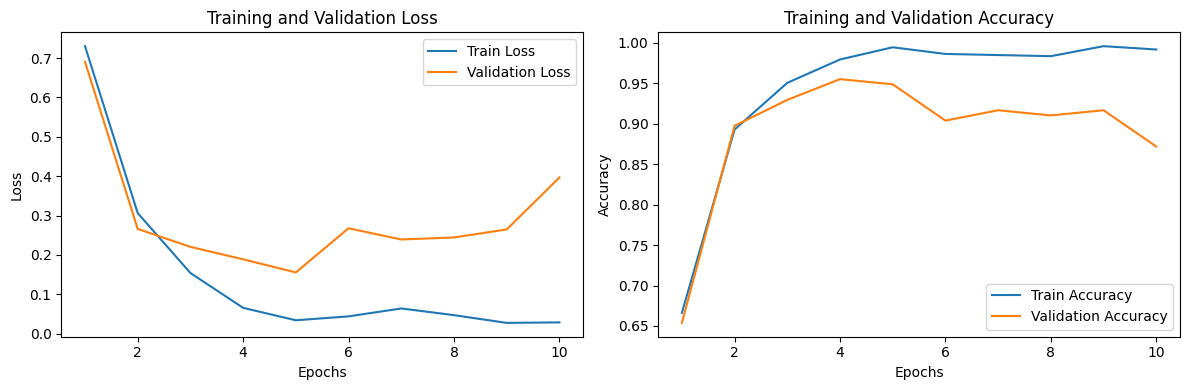

In [28]:
for model, name in models_dict.items():
    print(f'Training and Evaluating for {name}!')
    print('-' * 35)


    model.to(device)


    trainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())


    trainer.train(train_dataloader, test_dataloader, num_epochs=10)


    metrics = trainer.get_metrics()



correct_predictions = 0
total_samples = 0


model_effnet.eval()
model_mobilenet.eval()

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)


        outputs_effnet = model_effnet(inputs)
        outputs_mobilenet = model_mobilenet(inputs)

        prob_effnet = torch.softmax(outputs_effnet, dim=1)
        prob_mobilenet = torch.softmax(outputs_mobilenet, dim=1)


        avg_prob = (prob_effnet + prob_mobilenet) / 2

        _, predicted = torch.max(avg_prob, 1)


        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)


accuracy = correct_predictions / total_samples
print(f'Combined Validation Accuracy: {accuracy * 100:.2f}%')


plot_metrics(metrics)


In [29]:

print('Fine-tuning the last 20 layers for each model')
print('-' * 35)


for model, name in models_dict.items():
    num_layers_to_unfreeze = 20

    # For EfficientNet, the features are in model.features
    if isinstance(model, models.EfficientNet):
        # Unfreeze the last 'num_layers_to_unfreeze' layers
        children = list(model.features.children())
        for param in children[-num_layers_to_unfreeze:]:
            for p in param.parameters():
                p.requires_grad = True

    # For MobileNetV2, features are also in model.features
    elif isinstance(model, models.MobileNetV2):
        # Unfreeze the last 'num_layers_to_unfreeze' layers
        children = list(model.features.children())
        for param in children[-num_layers_to_unfreeze:]:
            for p in param.parameters():
                p.requires_grad = True

    # Move the model to the correct device (either GPU or CPU)
    model.to(device)
    print(f'The model {name} is ready!')
    print('-'*35)

Fine-tuning the last 20 layers for each model
-----------------------------------
The model EfficientNet is ready!
-----------------------------------
The model MobileNet is ready!
-----------------------------------


Training and Evaluating for EfficientNet!
-----------------------------------
Epoch 1/10 => Train Loss: 0.0701, Train Accuracy: 0.9794 | Val Loss: 0.5091, Val Accuracy: 0.8910
Epoch 2/10 => Train Loss: 0.0398, Train Accuracy: 0.9863 | Val Loss: 0.4468, Val Accuracy: 0.8846
Epoch 3/10 => Train Loss: 0.1104, Train Accuracy: 0.9588 | Val Loss: 0.4688, Val Accuracy: 0.8846
Epoch 4/10 => Train Loss: 0.0469, Train Accuracy: 0.9821 | Val Loss: 0.4471, Val Accuracy: 0.8910
Epoch 5/10 => Train Loss: 0.0592, Train Accuracy: 0.9849 | Val Loss: 0.4201, Val Accuracy: 0.8910
Epoch 6/10 => Train Loss: 0.0364, Train Accuracy: 0.9876 | Val Loss: 0.4221, Val Accuracy: 0.8974
Epoch 7/10 => Train Loss: 0.0344, Train Accuracy: 0.9904 | Val Loss: 0.5811, Val Accuracy: 0.8846
Epoch 8/10 => Train Loss: 0.0780, Train Accuracy: 0.9766 | Val Loss: 0.3739, Val Accuracy: 0.8910
Epoch 9/10 => Train Loss: 0.0581, Train Accuracy: 0.9863 | Val Loss: 0.3507, Val Accuracy: 0.8974
Epoch 10/10 => Train Loss: 0.0535, Train

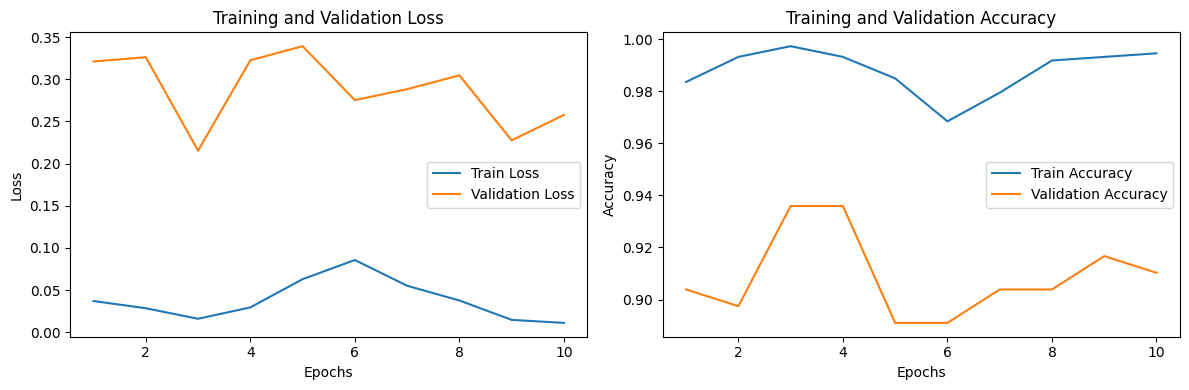

In [30]:
for model, name in models_dict.items():
    print(f'Training and Evaluating for {name}!')
    print('-' * 35)


    model.to(device)


    trainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())


    trainer.train(train_dataloader, test_dataloader, num_epochs=10)


    metrics = trainer.get_metrics()



correct_predictions = 0
total_samples = 0


model_effnet.eval()
model_mobilenet.eval()

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)


        outputs_effnet = model_effnet(inputs)
        outputs_mobilenet = model_mobilenet(inputs)

        prob_effnet = torch.softmax(outputs_effnet, dim=1)
        prob_mobilenet = torch.softmax(outputs_mobilenet, dim=1)


        avg_prob = (prob_effnet + prob_mobilenet) / 2

        _, predicted = torch.max(avg_prob, 1)


        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)


accuracy = correct_predictions / total_samples
print(f'Combined Validation Accuracy: {accuracy * 100:.2f}%')


plot_metrics(metrics)

In [31]:
## 5 fold cross validation
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import numpy as np

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, model_effnet, model_mobilenet):
        super().__init__()
        self.model_effnet = model_effnet
        self.model_mobilenet = model_mobilenet

    def forward(self, x):
        prob_effnet = torch.softmax(self.model_effnet(x), dim=1)
        prob_mobilenet = torch.softmax(self.model_mobilenet(x), dim=1)
        avg_prob = (prob_effnet + prob_mobilenet) / 2
        return avg_prob
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effnet = models.efficientnet_b0(pretrained=True)
model_effnet.classifier = nn.Sequential(
    nn.Flatten(), nn.Linear(1280, 1024), nn.ReLU(),
    nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, 3)
)
model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 3)

# Create combined model
combined_model = CombinedModel(model_effnet, model_mobilenet).to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0001)

# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Train model
    combined_model.train()
    for epoch in range(5):  # Use 5 epochs per fold
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate model
    combined_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = combined_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    all_accuracies.append(accuracy)
    print(f'Fold {fold+1} Accuracy: {accuracy * 100:.2f}%')

# Final Cross-Validation Accuracy
print(f'Average Accuracy over {k_folds} folds: {np.mean(all_accuracies) * 100:.2f}%')

Fold 1/5
Epoch 1, Loss: 0.9761
Epoch 2, Loss: 0.7728
Epoch 3, Loss: 0.6470
Epoch 4, Loss: 0.6057
Epoch 5, Loss: 0.5824
Fold 1 Accuracy: 83.56%
Fold 2/5
Epoch 1, Loss: 0.6229
Epoch 2, Loss: 0.5964
Epoch 3, Loss: 0.5913
Epoch 4, Loss: 0.5822
Epoch 5, Loss: 0.5791
Fold 2 Accuracy: 98.63%
Fold 3/5
Epoch 1, Loss: 0.5863
Epoch 2, Loss: 0.5899
Epoch 3, Loss: 0.5754
Epoch 4, Loss: 0.5777
Epoch 5, Loss: 0.5795
Fold 3 Accuracy: 98.63%
Fold 4/5
Epoch 1, Loss: 0.5725
Epoch 2, Loss: 0.5835
Epoch 3, Loss: 0.5746
Epoch 4, Loss: 0.5813
Epoch 5, Loss: 0.5776
Fold 4 Accuracy: 99.31%
Fold 5/5
Epoch 1, Loss: 0.5795
Epoch 2, Loss: 0.5761
Epoch 3, Loss: 0.5820
Epoch 4, Loss: 0.5738
Epoch 5, Loss: 0.5657
Fold 5 Accuracy: 99.31%
Average Accuracy over 5 folds: 95.89%


Evaluating on Validation Set...
Validation Accuracy: 86.54%
Confusion Matrix:
[[63  3  4]
 [ 2 26  2]
 [ 8  2 46]]


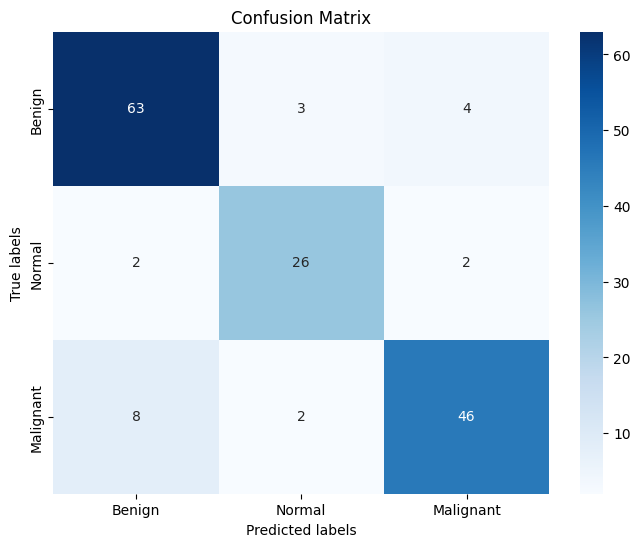

Precision: 0.87
Recall: 0.87
F1 Score: 0.87


In [32]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


print(f'Evaluating on Validation Set...')
correct_predictions = 0
total_samples = 0
all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct_predictions / total_samples
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


cm = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{cm}')
plot_confusion_matrix(cm, labels=['Benign', 'Normal', 'Malignant'])


precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


In [33]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import numpy as np

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, model_effnet, model_mobilenet):
        super().__init__()
        self.model_effnet = model_effnet
        self.model_mobilenet = model_mobilenet

    def forward(self, x):
        prob_effnet = torch.softmax(self.model_effnet(x), dim=1)
        prob_mobilenet = torch.softmax(self.model_mobilenet(x), dim=1)
        avg_prob = (0.8 * prob_effnet) + (0.2 * prob_mobilenet)
        return avg_prob
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effnet = models.efficientnet_b0(pretrained=True)
model_effnet.classifier = nn.Sequential(
    nn.Flatten(), nn.Linear(1280, 1024), nn.ReLU(),
    nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, 3)
)
model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 3)

# Create combined model
combined_model = CombinedModel(model_effnet, model_mobilenet).to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.0001)

# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=16, shuffle=False)

    # Train model
    combined_model.train()
    for epoch in range(5):  # Use 5 epochs per fold
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = combined_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate model
    combined_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = combined_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    all_accuracies.append(accuracy)
    print(f'Fold {fold+1} Accuracy: {accuracy * 100:.2f}%')

# Final Cross-Validation Accuracy
print(f'Average Accuracy over {k_folds} folds: {np.mean(all_accuracies) * 100:.2f}%')

Fold 1/5
Epoch 1, Loss: 1.0045
Epoch 2, Loss: 0.8064
Epoch 3, Loss: 0.6665
Epoch 4, Loss: 0.6147
Epoch 5, Loss: 0.6019
Fold 1 Accuracy: 82.88%
Fold 2/5
Epoch 1, Loss: 0.6353
Epoch 2, Loss: 0.6176
Epoch 3, Loss: 0.5943
Epoch 4, Loss: 0.5941
Epoch 5, Loss: 0.5789
Fold 2 Accuracy: 95.89%
Fold 3/5
Epoch 1, Loss: 0.6054
Epoch 2, Loss: 0.5909
Epoch 3, Loss: 0.5845
Epoch 4, Loss: 0.5882
Epoch 5, Loss: 0.5775
Fold 3 Accuracy: 97.95%
Fold 4/5
Epoch 1, Loss: 0.5832
Epoch 2, Loss: 0.5904
Epoch 3, Loss: 0.5842
Epoch 4, Loss: 0.5895
Epoch 5, Loss: 0.5908
Fold 4 Accuracy: 99.31%
Fold 5/5
Epoch 1, Loss: 0.5906
Epoch 2, Loss: 0.5788
Epoch 3, Loss: 0.5816
Epoch 4, Loss: 0.5799
Epoch 5, Loss: 0.5810
Fold 5 Accuracy: 99.31%
Average Accuracy over 5 folds: 95.07%


In [34]:
torch.save(combined_model.state_dict(), 'combined_model.pth')

In [ ]:
#!pip install torchcam
#!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

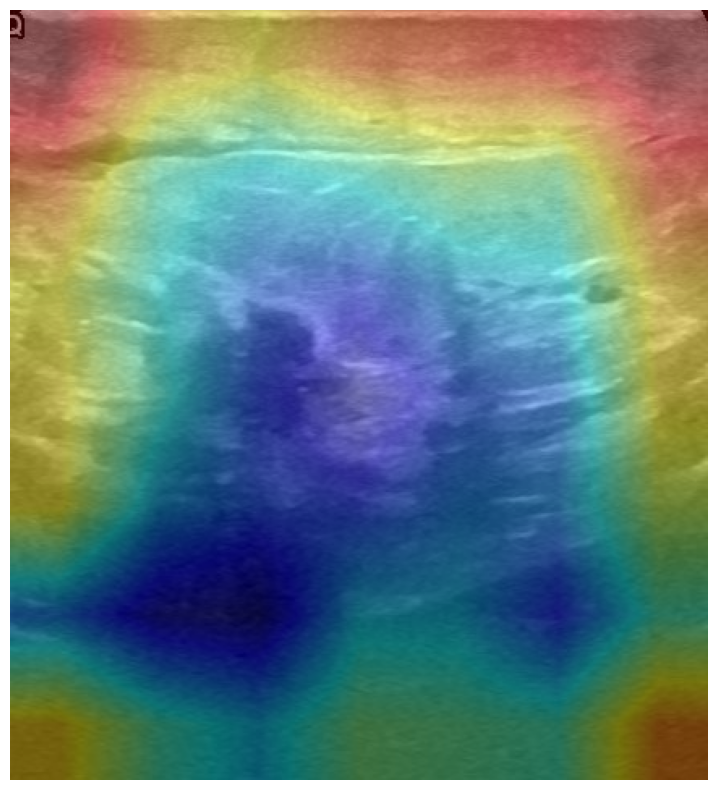

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

# Load your trained model
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load and preprocess the image
image_path = '/content/breast_ultrasound_data/Dataset_BUSI_with_GT/malignant/malignant (5).png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Set up storage for activations and gradients
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0]

# Get the last Conv2d layer of MobileNetV2
last_conv_layer = model.features[-1][0]  # Check your model architecture

# Register hooks
forward_handle = last_conv_layer.register_forward_hook(forward_hook)
backward_handle = last_conv_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1)

# Backward pass
model.zero_grad()
output[0, predicted_class].backward()

# Get activations and gradients
activation = activations['value'].detach()
gradient = gradients['value'].detach()

# Global average pooling on gradients
weights = gradient.mean(dim=[2, 3], keepdim=True)

# Weight the activations
weighted_activation = (weights * activation).sum(dim=1, keepdim=True)

# Apply ReLU
heatmap = F.relu(weighted_activation)
heatmap = heatmap.squeeze().cpu().numpy()

# Normalize heatmap
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on original image
superimposed_img = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

# Remove hooks
forward_handle.remove()
backward_handle.remove()